In [30]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')
import xgboost as xgb

In [31]:
# Load the datasets
train_data = pd.read_csv('Titanic_train.csv')
test_data = pd.read_csv('Titanic_test.csv')

In [32]:
# Exploratory Data Analysis (EDA)
# Check for missing values
print("Missing values in training set:\n", train_data.isnull().sum())
print("Missing values in testing set:\n", test_data.isnull().sum())

Missing values in training set:
 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
Missing values in testing set:
 PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


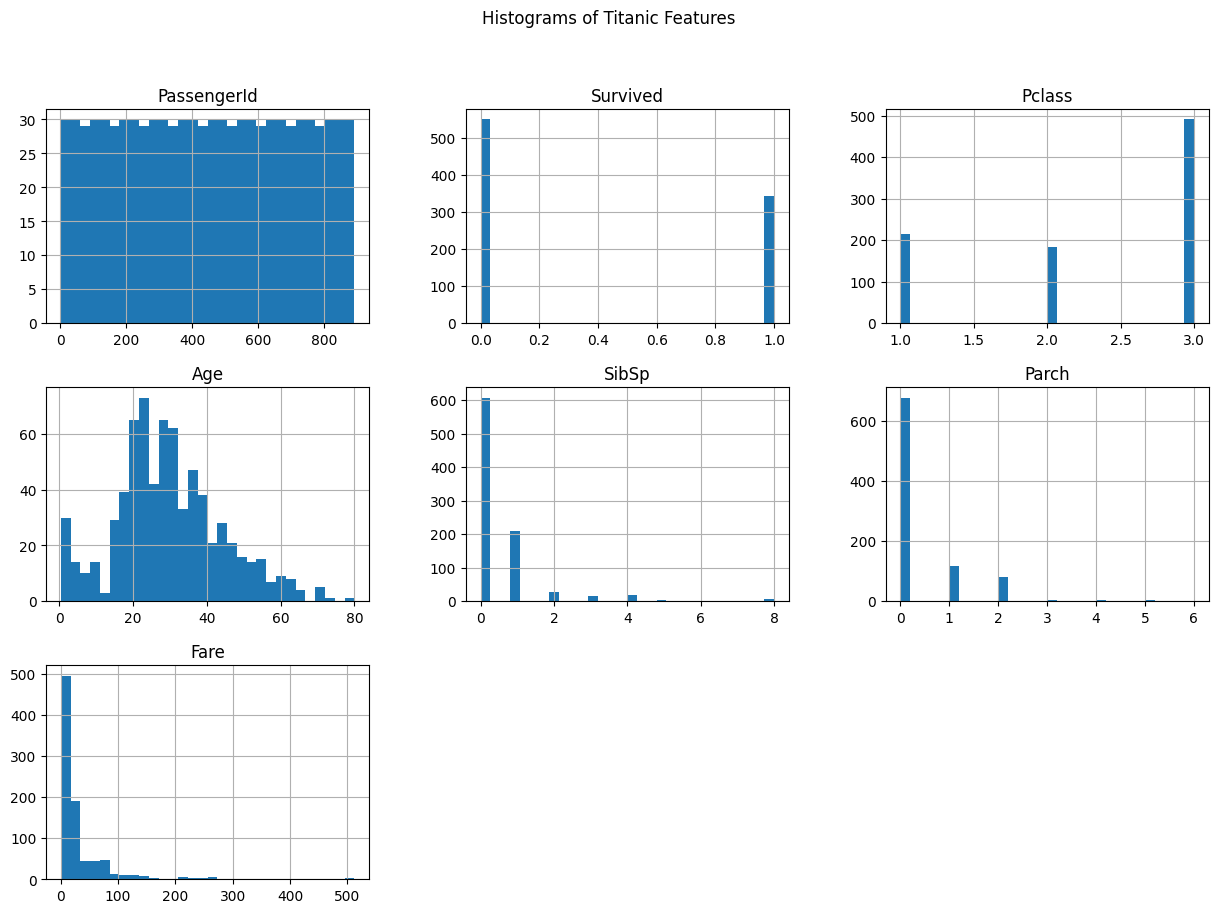

In [33]:
# Data distribution using histograms and box plots
train_data.hist(bins=30, figsize=(15, 10))
plt.suptitle("Histograms of Titanic Features")
plt.show()

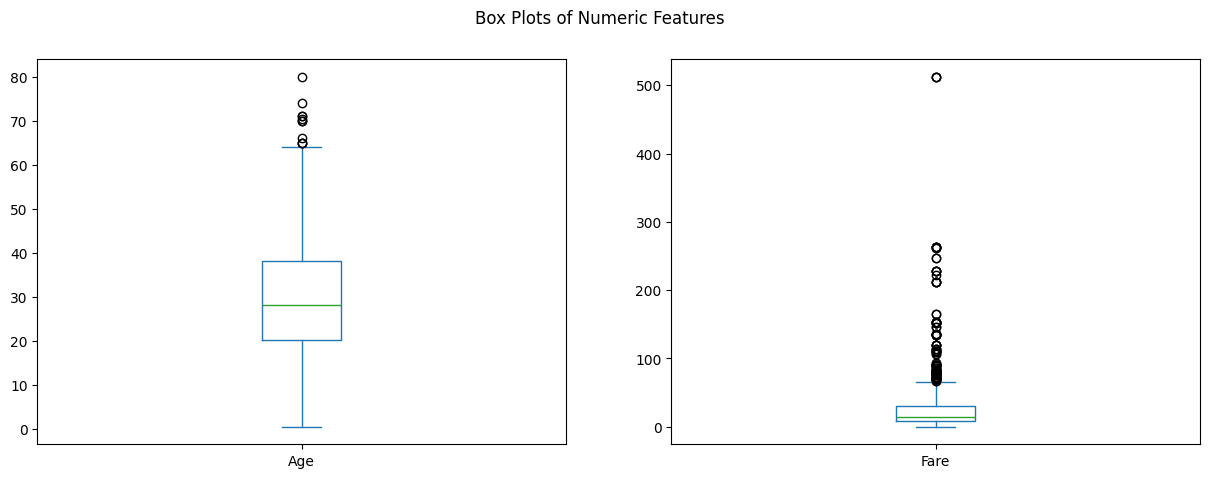

In [34]:
# Box plot for numeric features
numeric_features = ['Age', 'Fare']
train_data[numeric_features].plot(kind='box', subplots=True, layout=(1, len(numeric_features)), figsize=(15, 5))
plt.suptitle("Box Plots of Numeric Features")
plt.show()

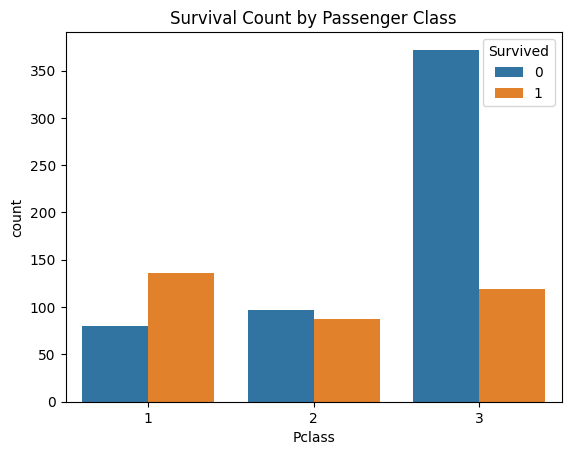

In [35]:
# Visualize relationships between features and survival
sns.countplot(data=train_data, x='Pclass', hue='Survived')
plt.title("Survival Count by Passenger Class")
plt.show()

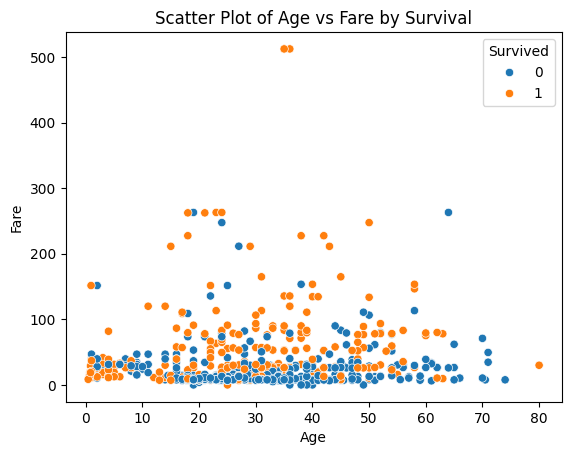

In [36]:
sns.scatterplot(data=train_data, x='Age', y='Fare', hue='Survived')
plt.title("Scatter Plot of Age vs Fare by Survival")
plt.show()

In [37]:
# Data Preprocessing
# Impute missing values
train_data['Age'].fillna(train_data['Age'].median(), inplace=True)
train_data['Embarked'].fillna(train_data['Embarked'].mode()[0], inplace=True)
test_data['Age'].fillna(test_data['Age'].median(), inplace=True)
test_data['Fare'].fillna(test_data['Fare'].median(), inplace=True)

In [38]:
# Encode categorical variables
train_data = pd.get_dummies(train_data, columns=['Sex', 'Embarked'], drop_first=True)
test_data = pd.get_dummies(test_data, columns=['Sex', 'Embarked'], drop_first=True)

In [39]:
# Drop unnecessary columns
train_data.drop(['Name', 'Ticket', 'Cabin'], axis=1, inplace=True)
test_data.drop(['Name', 'Ticket', 'Cabin'], axis=1, inplace=True)

In [40]:
# Align columns of train and test data
X_train = train_data.drop('Survived', axis=1)
y_train = train_data['Survived']
X_test = test_data[X_train.columns]

In [41]:
# Split the dataset into training and validation sets
X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [42]:
# Building Predictive Models
# Define evaluation metrics
def evaluate_model(y_true, y_pred):
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall:", recall_score(y_true, y_pred))
    print("F1 Score:", f1_score(y_true, y_pred))
    print("\nClassification Report:\n", classification_report(y_true, y_pred))

In [43]:
# LightGBM model
lgb_model = lgb.LGBMClassifier(random_state=42)
lgb_model.fit(X_train_split, y_train_split)
lgb_pred = lgb_model.predict(X_val)
print("LightGBM Performance:")
evaluate_model(y_val, lgb_pred)

[LightGBM] [Info] Number of positive: 268, number of negative: 444
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000073 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 433
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.376404 -> initscore=-0.504838
[LightGBM] [Info] Start training from score -0.504838
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [44]:
# XGBoost model
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train_split, y_train_split)
xgb_pred = xgb_model.predict(X_val)
print("XGBoost Performance:")
evaluate_model(y_val, xgb_pred)

XGBoost Performance:
Accuracy: 0.7932960893854749
Precision: 0.7534246575342466
Recall: 0.7432432432432432
F1 Score: 0.7482993197278912

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.83      0.82       105
           1       0.75      0.74      0.75        74

    accuracy                           0.79       179
   macro avg       0.79      0.79      0.79       179
weighted avg       0.79      0.79      0.79       179



In [45]:
# Hyperparameter tuning for XGBoost
xgb_params = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}
grid_search_xgb = GridSearchCV(xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
                               param_grid=xgb_params, scoring='f1', cv=3)
grid_search_xgb.fit(X_train_split, y_train_split)
print("Best XGBoost parameters:", grid_search_xgb.best_params_)

Best XGBoost parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}


In [46]:
# Hyperparameter tuning for LightGBM
lgb_params = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [-1, 3, 5]
}
grid_search_lgb = GridSearchCV(lgb.LGBMClassifier(random_state=42), param_grid=lgb_params, scoring='f1', cv=3)
grid_search_lgb.fit(X_train_split, y_train_split)
print("Best LightGBM parameters:", grid_search_lgb.best_params_)

[LightGBM] [Info] Number of positive: 178, number of negative: 296
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000074 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 321
[LightGBM] [Info] Number of data points in the train set: 474, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.375527 -> initscore=-0.508576
[LightGBM] [Info] Start training from score -0.508576
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [47]:
# Re-train models with best parameters
best_xgb_model = grid_search_xgb.best_estimator_
best_lgb_model = grid_search_lgb.best_estimator_

best_xgb_pred = best_xgb_model.predict(X_val)
best_lgb_pred = best_lgb_model.predict(X_val)

In [48]:
# Comparative Analysis
print("Optimized XGBoost Performance:")
evaluate_model(y_val, best_xgb_pred)

print("Optimized LightGBM Performance:")
evaluate_model(y_val, best_lgb_pred)

Optimized XGBoost Performance:
Accuracy: 0.8100558659217877
Precision: 0.8125
Recall: 0.7027027027027027
F1 Score: 0.7536231884057971

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.89      0.85       105
           1       0.81      0.70      0.75        74

    accuracy                           0.81       179
   macro avg       0.81      0.79      0.80       179
weighted avg       0.81      0.81      0.81       179

Optimized LightGBM Performance:
Accuracy: 0.8044692737430168
Precision: 0.7910447761194029
Recall: 0.7162162162162162
F1 Score: 0.75177304964539

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.87      0.84       105
           1       0.79      0.72      0.75        74

    accuracy                           0.80       179
   macro avg       0.80      0.79      0.80       179
weighted avg       0.80      0.80      0.80       179



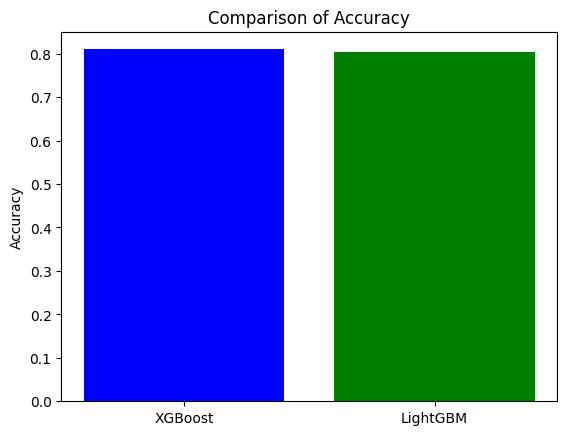

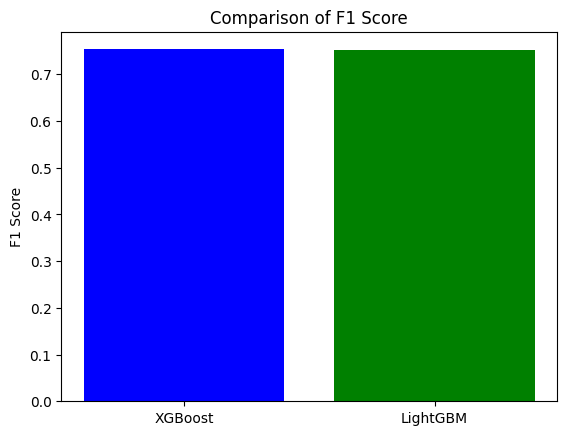

In [49]:
# Visualizing Results
models = ['XGBoost', 'LightGBM']
accuracies = [accuracy_score(y_val, best_xgb_pred), accuracy_score(y_val, best_lgb_pred)]
f1_scores = [f1_score(y_val, best_xgb_pred), f1_score(y_val, best_lgb_pred)]

plt.bar(models, accuracies, color=['blue', 'green'])
plt.title("Comparison of Accuracy")
plt.ylabel("Accuracy")
plt.show()

plt.bar(models, f1_scores, color=['blue', 'green'])
plt.title("Comparison of F1 Score")
plt.ylabel("F1 Score")
plt.show()